# Grafon

### Qué va a analizar nuestro grafo?

Analizar "gente que haya tenido experiencias facultativas similares" -> sacamos el factor temporal

### Qué queremos responder?

Qué electivas curso?

### Cómo es el grafo?

- Nodos: usuarios
- Aristas: cursar misma materia y "les fue parecido" -> -1 (en el final), 4-5, 6-7, 8-10
- Peso: porcentaje de similitud de materia+nota

### Dos formas de armar el análisis
- sólo correr sobre materias electivas
- correr sobre todas las materias, pero filtrar el output por electivas

### Ejemplo de conexión:

X y yo cursamos ...

In [ ]:
import pandas as pd

df = pd.read_pickle('fiuba-map-data.pickle')
df.sample(3)

,Padron,Carrera,Orientacion,Final de Carrera,materia_id,materia_nota,materia_cuatrimestre,optativas,aplazos
622,108193,informatica,Sistemas Distribuidos,tpp,75.72,-2.0,2025.0,NaN,NaN
17068,99796,informatica,Gestión Industrial de Sistemas,tpp,75.73,8.0,NaN,NaN,NaN
20050,96856,informatica,Gestión Industrial de Sistemas,tpp,NaN,NaN,NaN,"[{'id': 1, 'nombre': 'Materia Optativa', 'cred...",NaN


In [ ]:
categories = {
    4: 0,
    5: 0,
    6: 1,
    7: 1,
    8: 2,
    9: 2,
    10: 2
}

df_rel = df[['Padron', 'materia_id', 'materia_nota']].copy()

# Sacamos materias en final y a cursar
df_rel = df_rel[df_rel['materia_nota'] >= 4]
# Sacamos gente que no le pone la nota a su fiubamap
df_rel['promedio'] = df_rel.groupby('Padron')['materia_nota'].transform('mean')
df_rel = df_rel[df_rel['promedio'] > 5]

df_rel['materia_categoria'] = df_rel['materia_nota'].apply(lambda x: categories[x])
df_simil = pd.merge(df_rel, df_rel, on=['materia_id', 'materia_categoria'])
df_simil = df_simil[df_simil['Padron_x'] != df_simil['Padron_y']]
df_simil = df_simil.reset_index()
df_simil

,index,Padron_x,materia_id,materia_nota_x,promedio_x,materia_categoria,Padron_y,materia_nota_y,promedio_y
0,1,107840,CBC28,7.0,7.428571,1,107632,6.0,6.500000
1,2,107840,CBC28,7.0,7.428571,1,109131,7.0,7.333333
2,3,107840,CBC28,7.0,7.428571,1,98408,6.0,6.761905
3,4,107840,CBC28,7.0,7.428571,1,107614,6.0,6.222222
4,5,107840,CBC28,7.0,7.428571,1,43448118,6.0,7.812500
...,...,...,...,...,...,...,...,...,...
1407887,1418248,99627,75.48,7.0,7.553191,1,98338,7.0,7.317073
1407888,1418249,93445,75.48,7.0,6.974359,1,99627,7.0,7.553191
1407889,1418251,93445,75.48,7.0,6.974359,1,98338,7.0,7.317073
1407890,1418252,98338,75.48,7.0,7.317073,1,99627,7.0,7.553191


Esto resultaría en un grafo con pocos nodos y 1407892 de aristas, es decir demasiadas aristas. Por eso se busca un enfoque de unificar aristas mediante algún tipo de criterio y de esta forma tener sólo una arista entre padrones.

In [ ]:
import numpy as np

df_simil_agg = df_simil.groupby(['Padron_x', 'Padron_y']).agg(cant=('materia_id', 'count'))
df_simil_agg = df_simil_agg.reset_index()

df_simil_agg['Padron_min'] = df_simil_agg[['Padron_x', 'Padron_y']].min(axis=1)
df_simil_agg['Padron_max'] = df_simil_agg[['Padron_x', 'Padron_y']].max(axis=1)
df_simil_agg = df_simil_agg.drop_duplicates(['Padron_min', 'Padron_max']).reset_index()

df_simil_agg['inv_cant'] = df_simil_agg['cant'].max() - df_simil_agg['cant'] + 1
df_simil_agg

,index,Padron_x,Padron_y,cant,Padron_min,Padron_max,inv_cant
0,0,-1,0000,9,-1,0000,27
1,1,-1,02902,2,-1,02902,34
2,2,-1,100016,9,-1,100016,27
3,3,-1,100029,12,-1,100029,24
4,4,-1,100029asdasdasdasd,4,-1,100029asdasdasdasd,32
...,...,...,...,...,...,...,...
176484,351225,sadfsdfsdfgfasdfdsgsdfg,tplink,4,sadfsdfsdfgfasdfdsgsdfg,tplink,32
176485,351226,sadfsdfsdfgfasdfdsgsdfg,xasdasdasd,13,sadfsdfsdfgfasdfdsgsdfg,xasdasdasd,23
176486,351815,sadfsdfsdfgfdsgsdfg,tplink,4,sadfsdfsdfgfdsgsdfg,tplink,32
176487,351816,sadfsdfsdfgfdsgsdfg,xasdasdasd,13,sadfsdfsdfgfdsgsdfg,xasdasdasd,23


In [ ]:
df_simil_agg.sort_values('cant', ascending=False).head(25)

,index,Padron_x,Padron_y,cant,Padron_min,Padron_max,inv_cant
13192,13445,100687,99732,35,100687,99732,1
176170,338379,99616,99732,32,99616,99732,4
12670,12923,100687,102145,31,100687,102145,5
37593,39936,102145,102192,30,102145,102192,6
12731,12984,100687,103371,29,100687,103371,7
29035,30433,101601,102145,29,101601,102145,7
12676,12929,100687,102192,29,100687,102192,7
173774,309941,95897,99423,29,95897,99423,7
12049,12280,100680,101483,29,100680,101483,7
175084,322082,98124,98591,28,98124,98591,8


In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(df_simil_agg, 
                            source='Padron_x', 
                            target='Padron_y', 
                            edge_attr='inv_cant',
                            create_using=nx.Graph())

print(G)

Graph with 643 nodes and 176489 edges


In [ ]:
G.edges[('-1', '0000')]

{'inv_cant': 27}

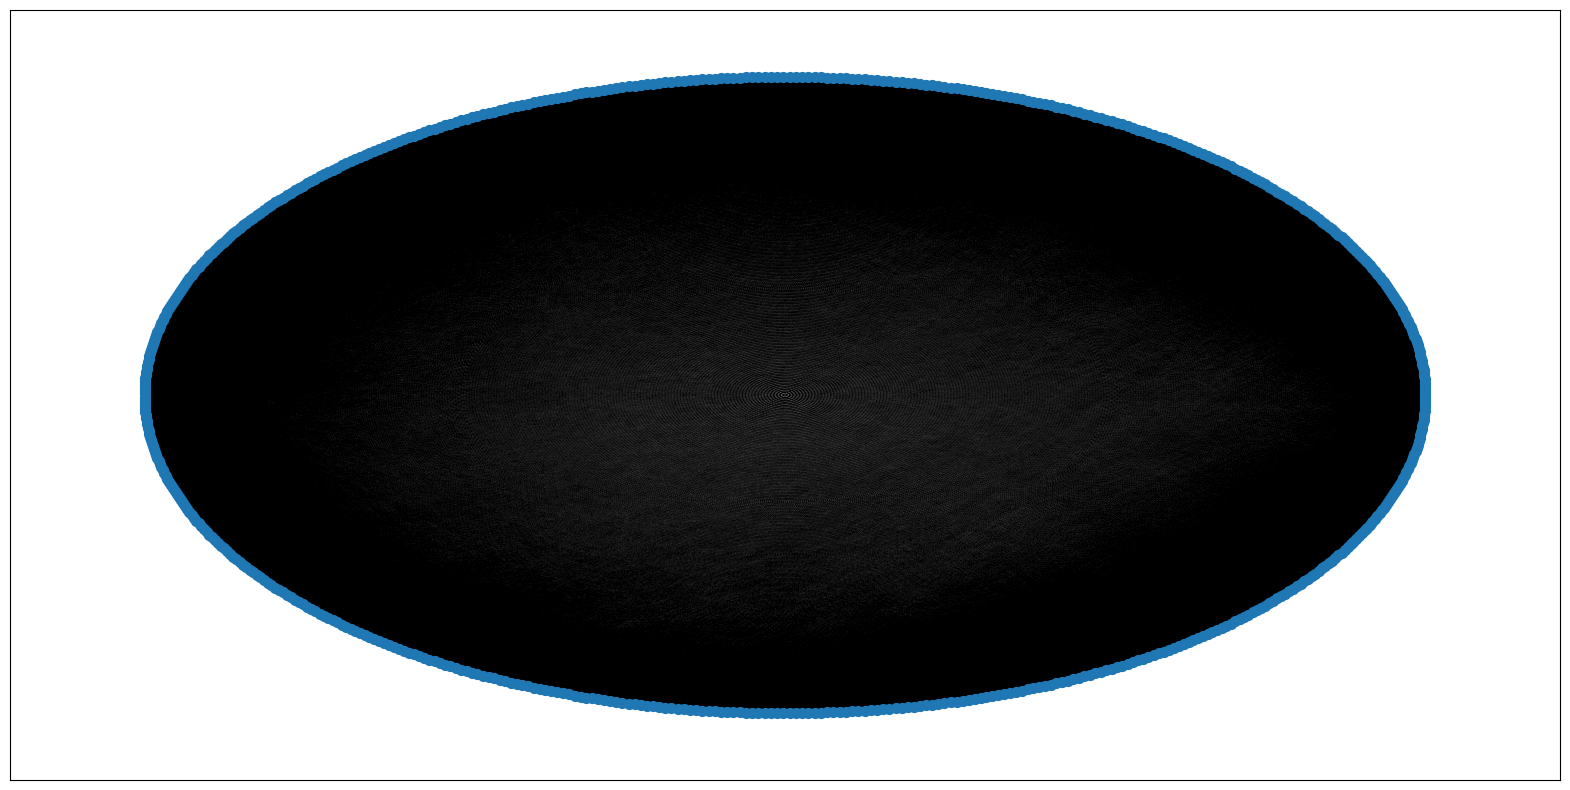

In [ ]:
# Veamos el grafo
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.circular_layout(G), width=0.005, node_size=50, with_labels=False)

## Stats generales del grafo

In [ ]:
print(f"""
  El diámetro de la red: {nx.diameter(G)}
  El grado promedio de la red: {sum([n[1] for n in G.degree()]) / len(G):.2f}
  TODO: Los allegados promedio de la red: 
  Puentes globales: {list(nx.bridges(G))}
""")


  El diámetro de la red: 3
  El grado promedio de la red: 548.95
  TODO: Los allegados promedio de la red: 
  Puentes globales: []



## Comunidades

In [ ]:
from networkx.algorithms import community
louvain = community.louvain_communities(G, weight='inv_cant', resolution=1.02)

In [ ]:
len(louvain)

20

In [ ]:
list(filter(lambda x: '101696' in x, louvain))

[{'-1',
  '02902',
  '100052',
  '100073',
  '100102',
  '100445',
  '100560',
  '100566',
  '100627',
  '100680',
  '100815',
  '100835',
  '100901',
  '101018',
  '101044',
  '101109',
  '101148',
  '101185',
  '101302',
  '101362',
  '101483',
  '101508',
  '101570',
  '101589',
  '101591',
  '101670',
  '101682',
  '101696',
  '101698',
  '101715',
  '101908',
  '102103',
  '102141',
  '102150',
  '102179',
  '102210',
  '102216',
  '102219',
  '102227',
  '102264',
  '102340',
  '102358',
  '102425',
  '102510',
  '102545',
  '102571',
  '102692',
  '102727',
  '102758',
  '102769',
  '102868',
  '102889',
  '102896',
  '103026',
  '103156',
  '103274',
  '103359',
  '103376',
  '103389',
  '103532',
  '103732',
  '103775',
  '103794',
  '103852',
  '103879',
  '103942',
  '103963',
  '103973',
  '104011',
  '104098',
  '104112',
  '104192',
  '104211',
  '104286',
  '104379',
  '104413',
  '104623',
  '104667',
  '104694',
  '104697I',
  '104728',
  '104851',
  '104880',
  '10492

In [ ]:
materias_obligatorias = [
  'CBC28', 'CBC27', 'CBC24', 'CBC3',
  'CBC5',  'CBC40', 'CBC',   '62.01',
  '61.03', '75.40', '62.03', '61.08',
  '75.41', '66.70', '75.12', '75.07',
  '61.09', '75.42', '75.06', '75.08',
  '71.14', '75.09', '75.52', '71.40',
  '75.15', '75.43', '75.10', '75.74',
  '75.44', '75.45', '75.46', '75.47',
  '75.59', '75.61', '75.65', '75.67',
  '75.66', '75.68', '75.00', '75.99'
]

def padrones_similares(padron, resolution):
    louvain = community.louvain_communities(G, weight='inv_cant', resolution=resolution)
    return list(filter(lambda x: padron in x, louvain))[0]

def materias_padron(padron):
    return df[df['Padron'] == padron]['materia_id'].values

def sugerir_electivas(padron, resolution=1):
    padrones = padrones_similares(padron, resolution)
    df_sugerencias = df_rel[df_rel['Padron'].isin(padrones)].groupby('materia_id').agg(cant=('materia_id', 'count'))
    df_sugerencias = df_sugerencias[~df_sugerencias.index.isin(materias_padron(padron))]
    df_sugerencias = df_sugerencias[~df_sugerencias.index.isin(materias_obligatorias)]
    df_sugerencias = df_sugerencias.sort_values('cant', ascending=False)
    return df_sugerencias

sugerir_electivas('0000', 1)

,cant
materia_id,
61.10,56
62.15,53
66.20,50
71.18,28
75.71,16
66.69,14
66.06,14
66.09,8
71.13,8


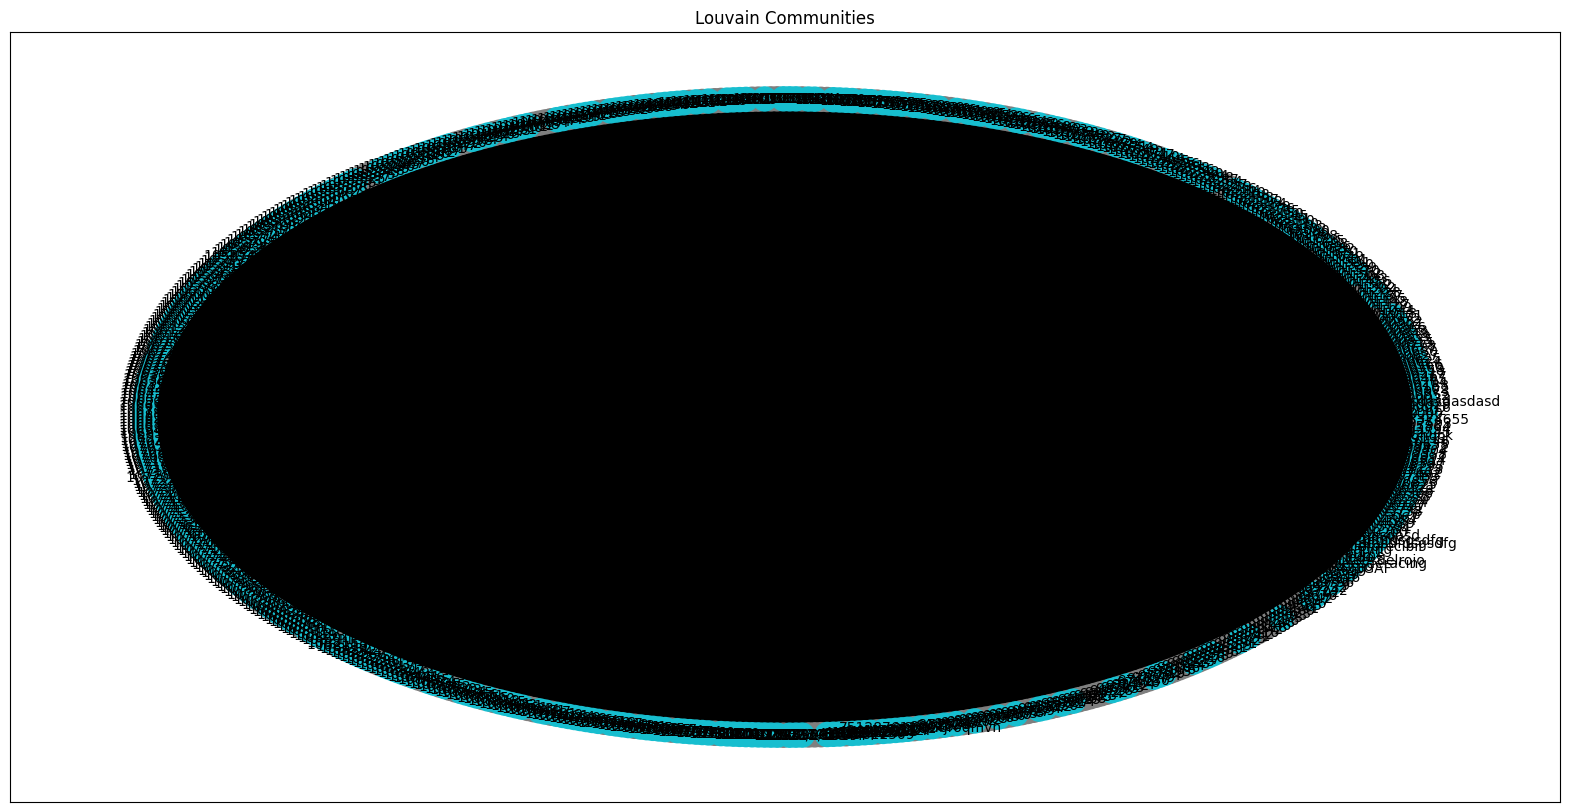

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# import random

# plt.figure(figsize=(20,10))

# draw_nodes = {}
# colors = random.sample(list(mcolors.TABLEAU_COLORS), len(louvain))
# for louvaincommunity, color in zip(louvain, colors):
#     draw_nodes.update({n: color for n in louvaincommunity})
    
# plt.title("Louvain Communities")
# nx.draw_networkx(G, 
#                  nodelist=draw_nodes.keys(), 
#                  node_color=list(draw_nodes.values()), 
#                  width=0.05, 
#                  pos=nx.circular_layout(G),
#                  font_size=10)

## Subcomunidades

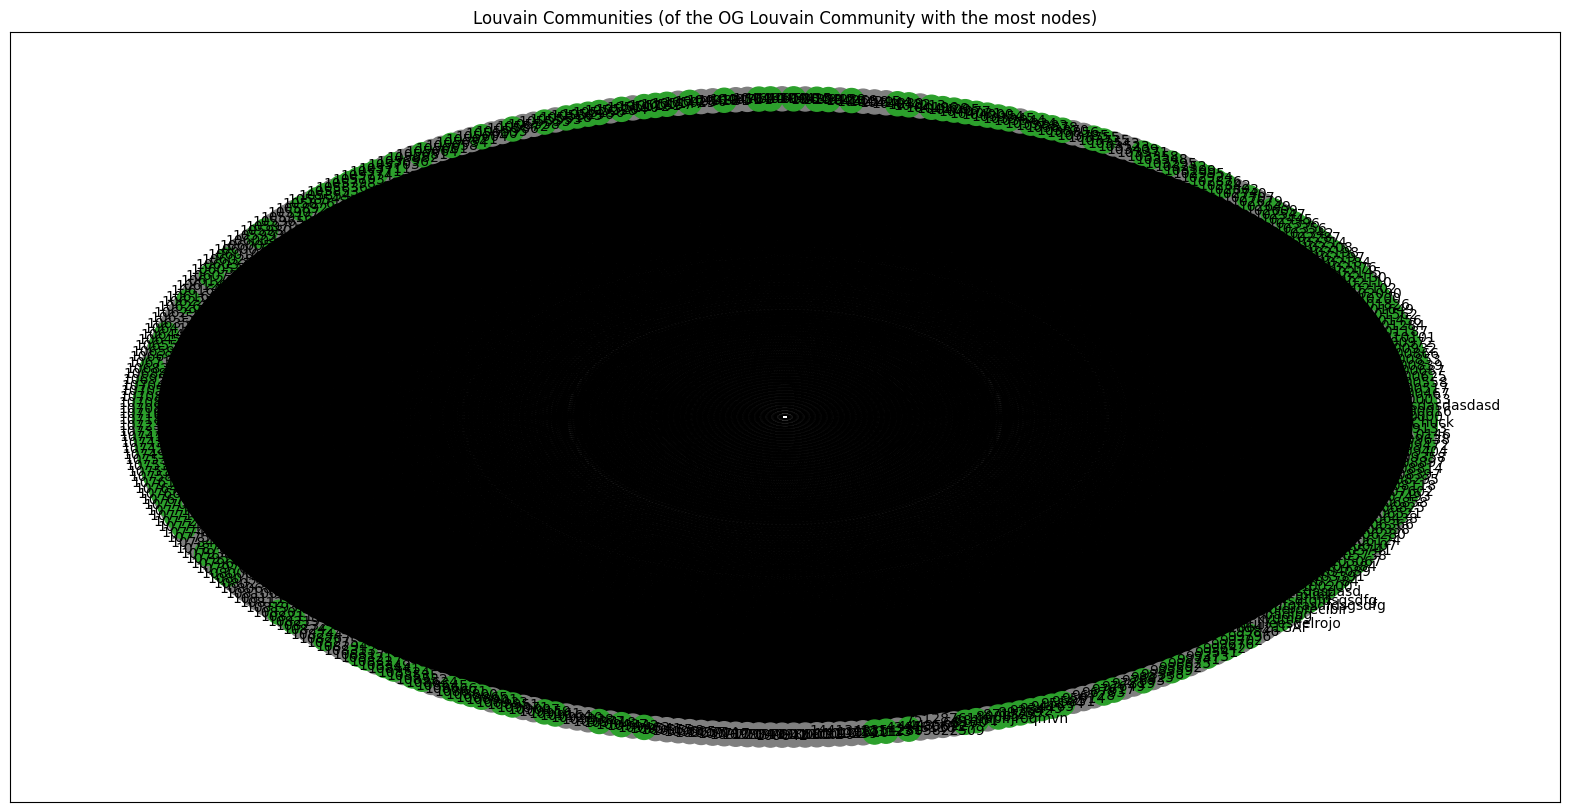

In [ ]:
# subnetwork = nx.subgraph(G, max(louvain, key=len))
# subnetwork_louvain = community.louvain_communities(subnetwork)
# plt.figure(figsize=(20,10))

# draw_nodes = {}
# colors = random.sample(list(mcolors.TABLEAU_COLORS), len(subnetwork_louvain))
# for louvain, color in zip(subnetwork_louvain, colors):
#     draw_nodes.update({n: color for n in louvain})
    
# plt.title("Louvain Communities (of the OG Louvain Community with the most nodes)")
# nx.draw_networkx(subnetwork, 
#                  nodelist=draw_nodes.keys(), 
#                  node_color=list(draw_nodes.values()), 
#                  width=0.05, 
#                  pos=nx.circular_layout(subnetwork),
#                  font_size=10)

In [ ]:
len(subnetwork_louvain)

2